In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer, execute
from qiskit.visualization import plot_histogram

In [2]:
svbackend = BasicAer.get_backend('statevector_simulator')
qmbackend = BasicAer.get_backend('qasm_simulator')

# Grover's Algorithm

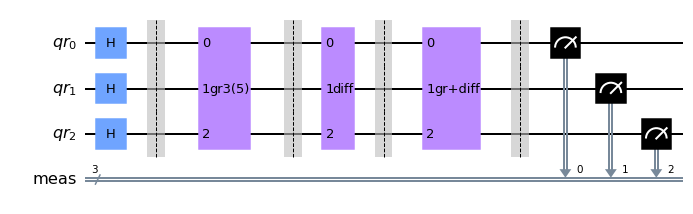

In [43]:
#Works for 2, 3 qubits databases

n = 3
marker = 5
Q = 2**n

qr = QuantumRegister(n, 'qr')
meas = ClassicalRegister(n, 'meas')
grover = QuantumCircuit(qr, meas)
grover.h(qr)
grover.barrier()
    
##################################################################################################################

def gr2(marker):
    if marker not in range(4):
        raise ValueError("marker must be in range")
    else:
        qc = QuantumCircuit(2)
        binval = format(marker,"02b")
        binval = binval[::-1]
        xlist = []
        for i in range(2):
            if binval[i] == '0':
                xlist.append(i)
        if xlist:
            qc.x(xlist)
        qc.cz(0,1)
        if xlist:
            qc.x(xlist)
        qc = qc.to_gate()
        qc.name = "gr2(%i)" % (marker)
    return qc

def gr3(marker):
    if marker not in range(8):
        raise ValueError("marker must be in range")
    else:
        qc = QuantumCircuit(3)
        binval = format(marker,"03b")
        binval = binval[::-1]
        xlist = []
        for i in range(3):
            if binval[i] == '0':
                xlist.append(i)
        if xlist:
            qc.x(xlist)
        qc.mcp(math.pi,[0,1],2)
        if xlist:
            qc.x(xlist)
        qc = qc.to_gate()
        qc.name = "gr3(%i)" % (marker)
    return qc

def gr3dual():
    qc = QuantumCircuit(3)
    qc.z(1)
    qc.cz([2,2,1],[1,0,0])
    qc = qc.to_gate()
    qc.name = "gr3dual(2,5)"
    return qc

if n == 2:
    grover.append(gr2(marker),qr)
elif n == 3:
    if marker == -1:
        grover.append(gr3dual(),qr)
    else:
        grover.append(gr3(marker),qr)
else:
    raise ValueError("Currently n is only 2 or 3")

##################################################################################################################

grover.barrier()

##################################################################################################################

def hdiff(n):
    qc = QuantumCircuit(n)
    qc.x(list(range(n)))
    qc.mcp(math.pi, list(range(n-1)), n-1)
    qc.x(list(range(n)))
    qc = qc.to_gate()
    qc.name = "hdiff"
    return qc

def diff(n):
    qc = QuantumCircuit(n)
    qc.h(list(range(n)))
    qc.append(hdiff(n),list(range(n)))
    qc.h(list(range(n)))
    qc = qc.to_gate()
    qc.name = "diff"
    return qc
    
grover.append(diff(n), qr)

##################################################################################################################

grover.barrier()

##################################################################################################################

def grdiff(n):
    qc = QuantumCircuit(n)
    if n == 2:
        qc.append(gr2(marker),list(range(n)))
    elif n == 3:
        if marker == -1:
            qc.append(gr3dual(),list(range(n)))
        else:
            qc.append(gr3(marker),list(range(n)))
    else:
        raise ValueError("Currently n is only 2 or 3")
    qc.append(diff(n),list(range(n)))
    qc = qc.to_gate()
    qc.name = "gr+diff"
    return qc

if marker == -1:
    k = 2
else:
    k = 1
t = math.ceil((math.pi/4)*math.sqrt(Q/k))
for c in range(t-2):
    grover.append(grdiff(n),qr)
    
##################################################################################################################

grover.barrier()
grover.measure(qr,meas)
grover.draw(output='mpl', fold=-1)

In [ ]:
job = execute(grover, qmbackend, shots=1)
result = job.result()
result.get_counts()
plot_histogram(result.get_counts())

In [ ]:
for output in result.get_counts():
    value = int(output,2)
if marker == value:
    print("Success")